In [4]:
import torch
from torch import nn
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import time
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import FeaturePyramidNetwork
import torch.nn.functional as F
from torchvision.ops import FeaturePyramidNetwork

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cpu")

In [9]:
# plot 4 metrics during training progress
def plot_training_progress(results_path):
    data = torch.load(results_path, map_location=torch.device('cpu'))
    fig, ax1 = plt.subplots()
    plt.plot(data["train_loss"], 'r', label = 'train_loss')
    plt.plot(data["val_loss"], 'm', label = 'val_loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    ax2=ax1.twinx()
    plt.plot(data["train_accuracy"], 'g', label = 'train_accuracy')
    plt.plot(data["val_accuracy"], 'b', label = 'val_accuracy')
    plt.legend(loc='lower right')
    ax2.set_ylabel('accuracy')

    plt.show()

In [10]:
results_path = './results/resnet_noaug_epoch25_lr3e-05_bs150.pt'

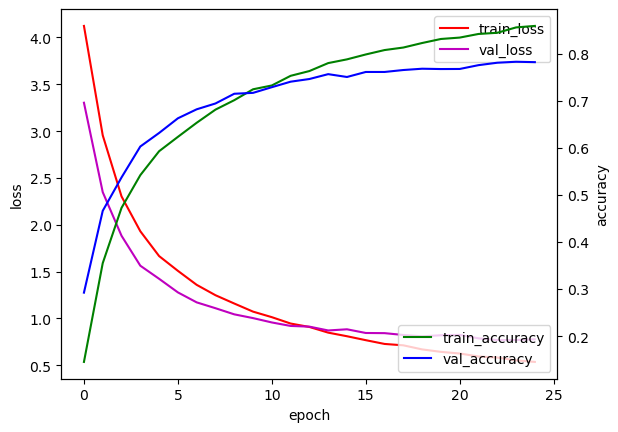

In [11]:
plot_training_progress(results_path)

In [12]:

data = torch.load(results_path, map_location=torch.device('cpu'))

# 打印表头
print("Epoch | Train Loss | Validation Loss | Train Accuracy | Validation Accuracy")

# 打印每个epoch的所有四个指标
for epoch in range(len(data["train_loss"])):
    train_loss = data["train_loss"][epoch]
    val_loss = data["val_loss"][epoch]
    train_accuracy = data["train_accuracy"][epoch]
    val_accuracy = data["val_accuracy"][epoch]
    
    print(f"{epoch} | {train_loss} | {val_loss} | {train_accuracy} | {val_accuracy}")


Epoch | Train Loss | Validation Loss | Train Accuracy | Validation Accuracy
0 | 4.123314571202218 | 3.303208966004221 | 0.1453184995569558 | 0.29239766081871343
1 | 2.95536021124346 | 2.348544157818498 | 0.355026090381018 | 0.46611627106983144
2 | 2.303149950437404 | 1.882904154474398 | 0.47238357782809887 | 0.5369797041623667
3 | 1.9311532258658801 | 1.563235152678101 | 0.5418430638968199 | 0.6026831785345718
4 | 1.66595134344746 | 1.423387070496877 | 0.5926454661809589 | 0.6314069487444101
5 | 1.5083429834393638 | 1.2782719361031634 | 0.6231170621246431 | 0.6625386996904025
6 | 1.3588239130241917 | 1.1716917019079836 | 0.6530471595943684 | 0.6816305469556243
7 | 1.2480933591290653 | 1.1092959638104474 | 0.6809589445702471 | 0.6940144478844169
8 | 1.1594205677972906 | 1.0438495407532613 | 0.7009943881067244 | 0.7146542827657378
9 | 1.0728356766515306 | 1.003773772464325 | 0.724131141084966 | 0.716546267629859
10 | 1.013700324167261 | 0.9572623663027343 | 0.7322536181943488 | 0.7285861

In [5]:
class ResNetFPN(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFPN, self).__init__()
        
        # Load pretrained ResNet model
        self.backbone = resnet50(pretrained=True)
        
        # Get the output size of different layers in ResNet
        self.conv1 = self.backbone.conv1
        self.bn1 = self.backbone.bn1
        self.relu = self.backbone.relu
        self.maxpool = self.backbone.maxpool
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        
        # Use Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(in_channels_list=[256, 512, 1024, 2048],
                                          out_channels=256)
        
        # Classification layers for each FPN output
        self.fc1 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU())
        self.fc4 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU())
        # self.fc1 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc2 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc3 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc4 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        
        # Final classification layer
        self.fc_final = nn.Linear(num_classes * 4, num_classes)

        # self.weights = nn.Parameter(torch.ones(4, dtype=torch.float32), requires_grad=True)  # Learnable weights

    def forward(self, x):
        # ResNet part
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        # FPN part
        features = self.fpn({"0": x1, "1": x2, "2": x3, "3": x4})
        
        # Classification part
        out1 = self.fc1(F.adaptive_avg_pool2d(features["0"], (1, 1)).view(x.size(0), -1))
        out2 = self.fc2(F.adaptive_avg_pool2d(features["1"], (1, 1)).view(x.size(0), -1))
        out3 = self.fc3(F.adaptive_avg_pool2d(features["2"], (1, 1)).view(x.size(0), -1))
        out4 = self.fc4(F.adaptive_avg_pool2d(features["3"], (1, 1)).view(x.size(0), -1))
        
        # Concatenate the classification results of each FPN output
        out = torch.cat((out1, out2, out3, out4), dim=1)
        # weights = F.softmax(self.weights, dim=0)
        # out = torch.cat([out1 * weights[0], out2 * weights[1], out3 * weights[2], out4 * weights[3]], dim=1)
        
        # Final classification
        out = self.fc_final(out)
        
        return out


In [14]:
# def get_cam_visualization_resnetfpn(model, img_paths):
#     # Identify the layers you want to visualize, adapt as needed
#     target_layers = [model.layer3, model.layer4]

#     # Instantiate the CAM extractor
#     cam_extractor = LayerCAM(model, target_layers)

#     # Create a figure with subplots
#     fig, axs = plt.subplots(2, 2, figsize=(12, 12))

#     # Loop through the input images and subplots
#     for i, (img_path, ax) in enumerate(zip(img_paths, axs.flatten())):
#         # Get the input image
#         img = Image.open(img_path)

#         # Preprocess the image for the model
#         input_tensor = transform(img).unsqueeze(0).to(device)

#         # Feed the input to the model
#         out = model(input_tensor)

#         # Retrieve the CAM for the predicted class
#         cams = cam_extractor(out.squeeze(0).argmax().item(), out)
#         fused_cam = cam_extractor.fuse_cams(cams)

#         # Overlay the CAM onto the image
#         result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
#         ax.imshow(result)
#         ax.axis('off')

#     # Show the figure
#     plt.show()

# # Instantiate your model
# model = ResNetFPN(106)
# model.load_state_dict(torch.load('./results/resnet_aug_weightfpn_epoch20_lr0.0003_bs150.pt', map_location=device)['model_state_dict'])

# # Use the function to visualize CAM for your selected images
# get_cam_visualization_resnetfpn(model, correct_paths)


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载模型
model = ResNetFPN(num_classes=106)
model.load_state_dict(torch.load('../model/results/resnet_aug_weightfpn_epoch25_lr5e-05_bs150.pt', map_location=torch.device('cpu'))['model_state_dict'])
model = model.to(device)

# 设置模型为评估模式
model.eval()

# 初始化预测和真实标签的列表
y_true = []
y_pred = []

# 使用模型进行预测
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())

# 计算评价指标
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵并进行可视化
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'test_loader' is not defined